# A machine learning approach for the classification of cardiac arrhythmia
The aim of this project is to determine the type of arrhythmia from the ECG recordings.

Eleonora Detić

### Data collection

Type of research:

- by purpose: **applied** - application in medicine for the early detection of cardiac arrhythmia

- by depth: **correlational** - we study how independent variable("diagnosis") is affected by several distinct dependent variables("age", "sex"..)

- by data type: **quantitative** - we have mathematical, measurable and comparable data

- by variable manipulation: **observational** - researchers observe patients

- by conclusion: **inductive** - we want to generalize things based on sample of pacients

- by time: **synchronous** - all samples are collected at the same time

- by source of information: **primary** - the researchers themselves spoke to the patients

- according to the method of data collection: **mixed** - a combination of data known about patients through medical records and ECG data measured under highly controlled conditions

Data collection method - **documentary** - **limited access**: the main source of data are the patient's medical records.

Data were collected **according to the rules of research ethics** - the names and id numbers of the patients were removed from the database for the privacy purpose.


### Data survey

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from scipy import stats
from pca import pca
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import sklearn.model_selection as model_selection
from sklearn.metrics import f1_score

In [3]:
df = pd.read_csv('data_arrhythmia.csv', delimiter=';')
df.dataframeName = 'data_arrhythmia.csv'
df.head()

,age,sex,height,weight,qrs_duration,p-r_interval,q-t_interval,t_interval,p_interval,qrs,...,KY,KZ,LA,LB,LC,LD,LE,LF,LG,diagnosis
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0,-0.1,3.9,25.4,62.8,7


In our data set, we have 452 patients and 279 features for each patient. Last column is interpreted as a number of heart arrhythmia claster. According to documentation, missing attribute values are distinguished with '?' so we will replace them with "NaN".

In [5]:
df = df.replace('?', np.NaN)
df.isna().sum().nlargest(10)


J               376
P                22
T                 8
QRST              1
heart_rate        1
age               0
sex               0
height            0
weight            0
qrs_duration      0
dtype: int64

In [53]:
#df.drop(["J"], axis=1, inplace=True)
#As we can see, in column 'J' we have a lof of missing values, more than 80%, so we will drop that column.

age                                                   
     count       mean        std  min   25%   50%   75%   max
sex                                                          
0    203.0  47.546798  16.519761  0.0  37.5  47.0  59.0  80.0
1    249.0  45.594378  16.404173  1.0  34.0  46.0  58.0  83.0

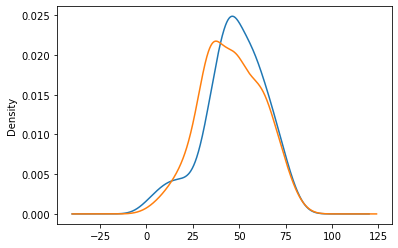

In [6]:
df.groupby('sex').age.plot(kind='kde') 
df[["sex", "age"]].groupby("sex").describe()

The above results show the distribution graph and descriptive statistics, for both women and men.

As for the other columns, since these variables are continuous, the first idea could be to hope for a normal distribution and then try to preserve the variability of the data by randomly simulate the missing values. <br> For this purpose, we perform well know **Kolmogorov–Smirnov** test.

In [7]:
print(stats.kstest(df[df['P'].notnull()]['P'].astype(int), 'norm'))
print(stats.kstest(df[df['T'].notnull()]['T'].astype(int), 'norm'))
print(stats.kstest(df[df['QRST'].notnull()]['QRST'].astype(int), 'norm'))
print(stats.kstest(df[df['heart_rate'].notnull()]['heart_rate'].astype(int), 'norm'))

KstestResult(statistic=0.9255811086972653, pvalue=0.0)
KstestResult(statistic=0.847749201067469, pvalue=0.0)
KstestResult(statistic=0.8168319201501881, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)


This assumption was obviously too ambitious. For all columns, the p value turned out to be very small and the test statistics very large. <br> So our conclusion is that at each standard level of significance, we reject the null hypothesis, that is, that our data **do not follow** a normal distribution. <br>
The next idea is standard. We will replace the missing values with the mean of each column.

In [7]:
imp= SimpleImputer(missing_values=np.NaN, strategy='mean')
idf=pd.DataFrame(imp.fit_transform(df))
idf.columns=df.columns
idf.index=df.index
df = idf
df.isna().sum().nlargest(10)

age             0
sex             0
height          0
weight          0
qrs_duration    0
p-r_interval    0
q-t_interval    0
t_interval      0
p_interval      0
qrs             0
dtype: int64

Finally, there are no more missing values in our data.

## Principal Component Analysis

Before using PCA, the first step is to scale the features in our data. 

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [279] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [103] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[103]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


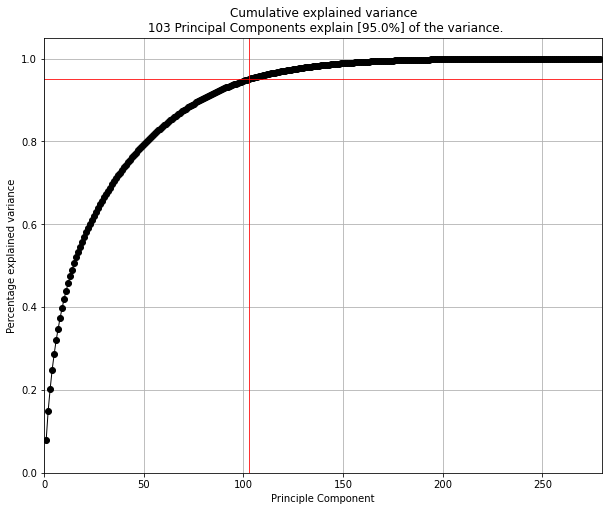

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 103 Principal Components explain [95.0%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 432x288 with 0 Axes>

In [294]:
from pca import pca

X = df.iloc[:,0:279]
y = df.iloc[:,-1:].values 
X = StandardScaler().fit_transform(X)
#y = StandardScaler().fit_transform(y) inače greska jer mi algoritram ocekuje intove kao class


model = pca()
out = model.fit_transform(X)
model.plot()

As we can see, 103 Principal Components explain 95% of the variance and 150 Principal Components explain about 99% of the variance. <br> So, our next step is to find those important features.

In [270]:
model.compute_topfeat()

,PC,feature,loading,type
0,PC1,218,-0.189314,best
1,PC2,278,0.186085,best
2,PC3,248,-0.192093,best
3,PC4,232,0.158709,best
4,PC5,217,0.190592,best
...,...,...,...,...
371,PC255,269,0.331164,weak
372,PC211,270,-0.197972,weak
373,PC248,272,0.227078,weak
374,PC10,276,-0.208259,weak


(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'103 Principal Components explain [95.0%] of the variance'}, xlabel='PC1 (7.96% expl.var)', ylabel='PC2 (7.06% expl.var)'>)

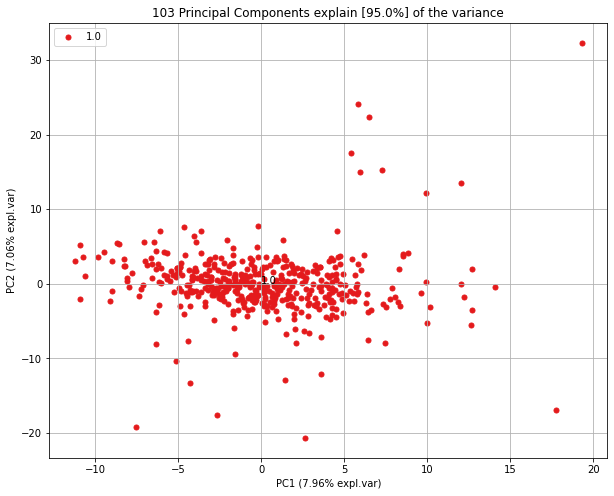

In [271]:
model.scatter()

#### Detection of outliers using PCA

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'103 Principal Components explain [95.0%] of the variance'}, xlabel='PC1 (7.96% expl.var)', ylabel='PC2 (7.06% expl.var)'>)

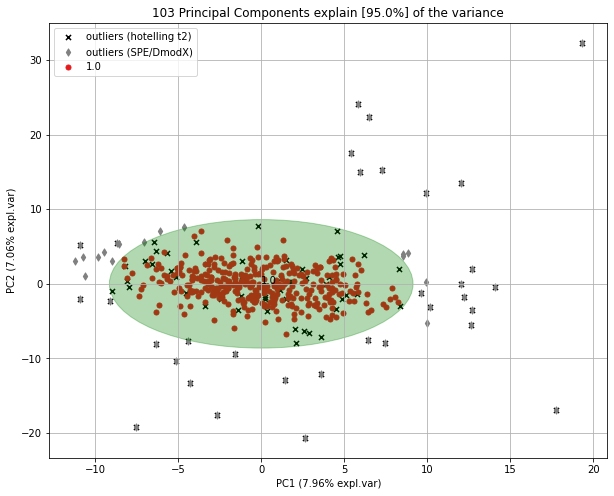

In [272]:
model.scatter(legend=True, SPE=True, hotellingt2=True)

In [295]:
Xoutliers = X[out['outliers']['y_bool'],:]
X_no_outliers = X[~out['outliers']['y_bool'],:]
y_no_outliers = y[~out['outliers']['y_bool'],:]

In [274]:
pd.DataFrame(X_no_outliers)

,0,1,2,3,4,5,6,7,8,9,...,269,270,271,272,273,274,275,276,277,278
0,1.734439,-1.107520,0.641327,0.713814,0.135505,0.844945,0.113709,0.113809,1.201469,-1.094661,...,0.004037,0.508843,-0.013839,0.278621,-0.079546,0.0,1.109553,1.177737,0.294603,1.078670
1,0.579312,0.902918,-0.031998,-0.251644,-0.516072,0.420769,1.013301,-0.588564,-1.977064,-0.191203,...,-0.327703,0.508843,-0.157972,0.728573,-0.079546,0.0,-0.906889,0.616126,0.079613,0.504874
2,0.518516,-1.107520,0.237332,1.558590,0.721924,1.045871,0.383587,0.254284,2.054247,-0.125096,...,0.667516,0.508843,0.908612,-0.371310,-0.079546,0.0,-0.330763,0.967133,1.132324,1.739077
3,1.734439,-1.107520,0.641327,0.713814,-0.059968,0.577044,-0.216141,0.198094,0.503742,-1.094661,...,-0.161833,0.508843,1.168051,-1.071235,-0.079546,0.0,-1.771079,1.879751,0.450286,1.804035
4,-0.393427,0.902918,-0.166663,-0.975738,-0.776702,-0.583860,0.293628,-1.038082,-0.504085,0.954648,...,-0.161833,0.508843,-0.734504,0.728573,-0.079546,0.0,-0.330763,-0.156089,-0.372608,-0.485736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,-1.609350,0.902918,-0.247462,-0.674032,-0.516072,-0.092708,-0.126182,-0.110950,-0.387798,0.205438,...,0.501646,0.508843,-0.532718,0.378610,-0.079546,0.0,-0.042700,0.756529,-0.127964,0.526527
363,0.396924,0.902918,-0.166663,0.110403,-0.581229,0.978896,0.443560,-0.448089,1.046419,-1.557409,...,0.501646,0.508843,-1.368689,-1.771161,-0.079546,0.0,0.533427,-0.436895,-1.758926,-1.622502
364,-0.575815,-1.107520,0.641327,1.015520,0.721924,-0.405260,-0.186154,0.872372,-0.659136,1.152968,...,-0.327703,0.508843,1.888716,-0.071342,-0.079546,0.0,-0.330763,0.826730,1.384382,1.782383
365,-0.879796,0.902918,-0.301328,-0.794714,0.265820,-1.097337,0.563505,1.349985,-1.046762,0.447829,...,0.833385,-0.220727,0.850959,0.378610,-0.079546,0.0,-0.042700,0.826730,0.420632,0.927101


[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [279] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[150]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


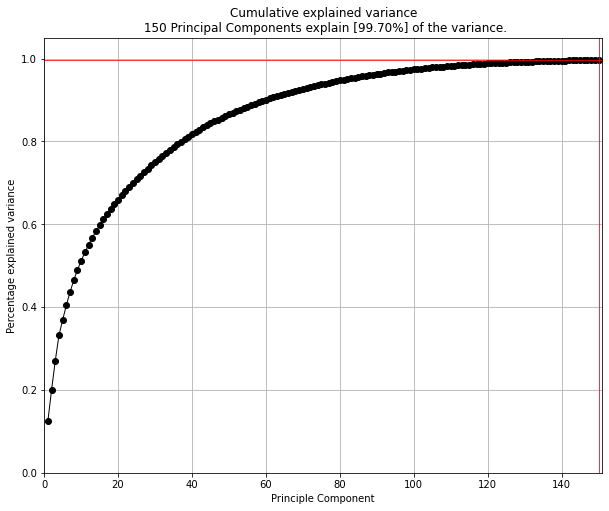

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 150 Principal Components explain [99.70%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 432x288 with 0 Axes>

In [296]:
model = pca(n_components=150)
out = model.fit_transform(X_no_outliers)
model.plot()

In [312]:
X_after_pca = np.array(model.transform(X_no_outliers))

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.


### Classification 

In [328]:
#scaler = StandardScaler()

X = X_after_pca
y = y_no_outliers

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.70, test_size=0.30,)

#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

#### Support Vector Machine

In [346]:
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1).fit(X_train, y_train)
poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))
rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (Polynomial Kernel):  53.15
F1 (Polynomial Kernel):  38.39
Accuracy (RBF Kernel):  51.35
F1 (RBF Kernel):  34.85


/Users/eleonoradetic/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/eleonoradetic/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


#### Logistic Regression Algorithm

In [344]:
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(X_train, y_train)
lm_accuracy = accuracy_score(y_test, lm.predict(X_test))
print('Accuracy (Logistric Regression): ', "%.2f" % (lm_accuracy * 100))

Accuracy (Logistric Regression):  59.46


/Users/eleonoradetic/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


#### K-Nearest Neighbors Algorithm

In [345]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
ypred = knn.predict(X_test) 
knn_accuracy = accuracy_score(y_test,ypred)
print('Accuracy (K-Nearest Neighbors): ', "%.2f" % (knn_accuracy *100))

Accuracy (K-Nearest Neighbors):  54.05


/Users/eleonoradetic/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


#### Random Forest Algorithm

In [327]:
ranf = RandomForestClassifier(n_estimators = 70, criterion = 'entropy', random_state = 42)
ranf.fit(X_train, y_train)
ypred = ranf.predict(X_test) 
ranf_accuracy = accuracy_score(y_test,ypred)
print('Accuracy (K-Nearest Neighbors): ', "%.2f" % (ranf_accuracy *100))

/var/folders/d3/xr9k6gp148s_pc6q399vjm2h0000gn/T/ipykernel_1279/3919366424.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  ranf.fit(X_train, y_train)


Accuracy (K-Nearest Neighbors):  63.06


## Conclusion 